# M2.1 Support Vector Machines
 [![View notebooks on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/cltl/ml4nlp_tutorial_notebooks/blob/main/my_notebooks/m2_1_support_vector_machines.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cltl/ml4nlp_tutorial_notebooks/blob/main/my_notebooks/m2_1_support_vector_machines.ipynb)  


### Learning Objectives
By working through this notebook, you will learn:
1. What Support Vector Machines (SVMs) are
2. Understand the effect of soft margin and the parameter C
3. Understand the importance of the kernel
4. Be able to apply SVM for text classification 

 ## 1. Introduction to Support Vector Machines

 Support Vector Machines (SVMs) are supervised learning models used for classification tasks.
 The core idea is to find a hyperplane that separates data points of different classes with the maximum margin. The margin is the distance between the hyperplane and the nearest data points from each class, called support vectors.

In [1]:
# ignore warning messages for cleaner output of the website
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt  
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score


 ## 2. Mathematical Formulation

 ### 2.1 The Hyperplane
 For classification we can talk about a "hyperplane" which divides the space. When you have a two dimensional plot with an x and y-axis, a hyperplane can be a line which divides this 2D space. But when we have many features, this means our input dimension is much higher than two, so generally we can call this dividing part of a feature space a hyperplane. 

 A hyperplane in n-dimensional space is defined by:

 $$w^T x + b = 0$$

 Where:

 - $w$ is the weight vector (normal to the hyperplane)
 - $x$ is the input feature vector
 - $b$ is the bias term

 ### 2.2 Classification Rules
 For a given point $x$:
 - $w^T x + b = 0$ → point lies exactly on the hyperplane (no class assigned)
 - $w^T x + b > 0$ → point belongs to class A (positive class, $y = +1$)
 - $w^T x + b < 0$ → point belongs to class B (negative class, $y = -1$)

 ### 2.3 Margin Definition
 We define two parallel hyperplanes that create the margin:
 - $H_1: w^T x + b \geq +1$ for $y_i = +1$
 - $H_2: w^T x + b \leq -1$ for $y_i = -1$

 The distance between $H_1$ and $H_2$ is $\frac{2}{||w||}$, which is the margin we want to maximize.

 <!-- ### 2.4 Optimization Objective
 **Hard Margin SVM** (linearly separable case):

 Maximize: $\frac{2}{||w||}$

 Equivalent to minimizing: $\frac{1}{2}||w||^2$

 Subject to: $y_i(w^T x_i + b) \geq 1$ for all $i$


 **Soft Margin SVM** (non-linearly separable case):

 Minimize: $\frac{1}{2}||w||^2 + C \sum_{i=1}^{n} \xi_i$

 Subject to: $y_i(w^T x_i + b) \geq 1 - \xi_i$ and $\xi_i \geq 0$

 Where:
 - $\xi_i$ are slack variables that allow some misclassification
 - $C$ is the regularization parameter controlling the trade-off between maximizing
   the margin and minimizing classification errors -->

## 3. Hard Margin SVM Visualization

In a hard margin SVM, we assume the data is linearly separable. All points must be correctly classified with no violations of the margin constraints.

**Optimization Objective - Hard Margin SVM** (linearly separable case)
 <!-- **Hard Margin SVM** (linearly separable case): -->

 Maximize: $\frac{2}{||w||}$

 Equivalent to minimizing: $\frac{1}{2}||w||^2$

 Subject to: $y_i(w^T x_i + b) \geq 1$ for all $i$


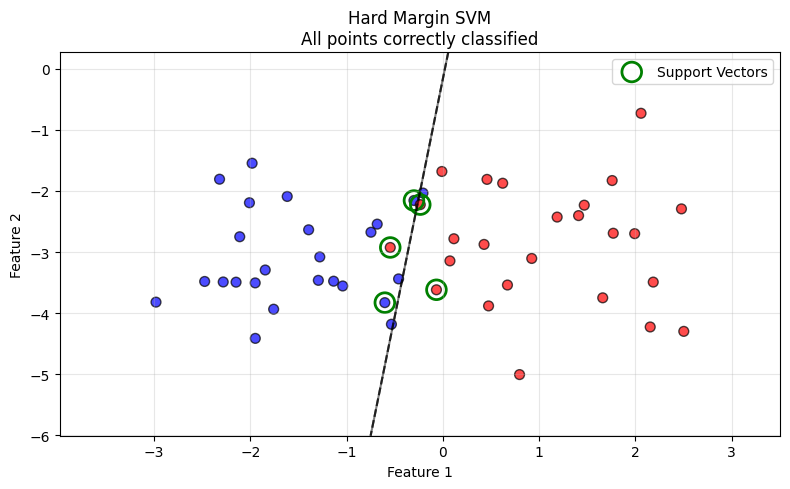

Number of support vectors: 5


In [2]:
# Generate linearly separable data
np.random.seed(41)
X_hard, y_hard = make_blobs(n_samples=50, centers=2, n_features=2, 
                            center_box=(-3, 3), cluster_std=0.8)

# Train hard margin SVM (large C approximates hard margin)
svm_hard = SVC(kernel='linear', C=1e10)
svm_hard.fit(X_hard, y_hard)

# Plotting function
def plot_svm_decision_boundary(X, y, model, title):
    plt.figure(figsize=(8, 5))
    
    # Create mesh for decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Get decision function values
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and margins
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], 
                alpha=0.5, linestyles=['--', '-', '--'])
    
    # Plot data points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr', 
                edgecolors='k', alpha=0.7)
    
    # Highlight support vectors
    plt.scatter(model.support_vectors_[:, 0], 
                model.support_vectors_[:, 1],
                s=200, linewidth=2, facecolors='none', 
                edgecolors='green', label='Support Vectors')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
plot_svm_decision_boundary(X_hard, y_hard, svm_hard, 
                           'Hard Margin SVM\nAll points correctly classified')
plt.show()

print(f"Number of support vectors: {len(svm_hard.support_vectors_)}")


**Observation:**
- We see that the decision boundary separates the two distributions pretty well, and that only a few points very close to the border are relevant for calculating the support vectors. 

 ## 4. Soft Margin SVM and the C Parameter
 In practice, data is rarely perfectly separable. Soft margin SVM allows some misclassifications by introducing slack variables $\xi_i$.

 The parameter $C$ controls this trade-off:
 - **Large C**: Penalizes misclassifications heavily → narrow margin, fewer errors
 - **Small C**: Allows more misclassifications → wide margin, potentially more errors


 **Optimization Objective - Soft Margin SVM** (non-linearly separable case):

 Minimize: $\frac{1}{2}||w||^2 + C \sum_{i=1}^{n} \xi_i$

 Subject to: $y_i(w^T x_i + b) \geq 1 - \xi_i$ and $\xi_i \geq 0$

 Where:
 - $\xi_i$ are slack variables that allow some misclassification
 - $C$ is the regularization parameter controlling the trade-off between maximizing
   the margin and minimizing classification errors


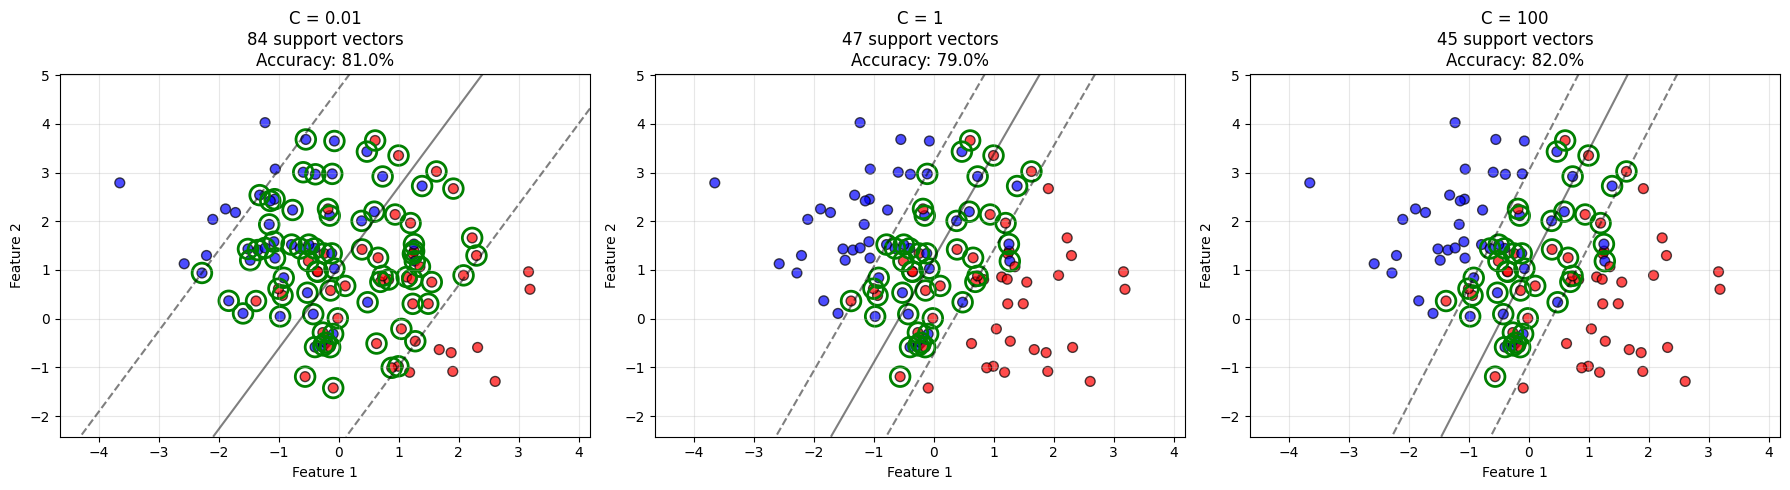

In [3]:
# Generate data with some overlap
np.random.seed(42)
X_soft, y_soft = make_blobs(n_samples=100, centers=2, n_features=2,
                            center_box=(-2, 2), cluster_std=1.2)

# Train SVMs with different C values
C_values = [0.01, 1, 100]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, C in enumerate(C_values):
    svm = SVC(kernel='linear', C=C)
    svm.fit(X_soft, y_soft)
    acc = svm.score(X_soft, y_soft)
    
    ax = axes[idx]
    
    # Create mesh
    x_min, x_max = X_soft[:, 0].min() - 1, X_soft[:, 0].max() + 1
    y_min, y_max = X_soft[:, 1].min() - 1, X_soft[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1],
               alpha=0.5, linestyles=['--', '-', '--'])
    ax.scatter(X_soft[:, 0], X_soft[:, 1], c=y_soft, s=50, 
               cmap='bwr', edgecolors='k', alpha=0.7)
    ax.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1],
               s=200, linewidth=2, facecolors='none', 
               edgecolors='green')
    
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(f'C = {C}\n{len(svm.support_vectors_)} support vectors\nAccuracy: {acc*100:.1f}%')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


**Observations:**
- Small C: Wide margin, more support vectors, some misclassifications tolerated
- Large C: Narrow margin, fewer support vectors, tries to classify all points correctly
- We also see that in this case theaccuracy does not  clearly scale with the parameter for C.

## 5. Kernels
When data is not linearly separable in the original feature space, kernels can map the data to a higher-dimensional space where linear separation becomes possible.



Common kernels:
- **Linear**: $K(x_i, x_j) = x_i^T x_j$ (no transformation, linear classifier)
- **Polynomial**: $K(x_i, x_j) = (x_i^T x_j + c)^d$
- **Gaussian (RBF)**: $K(x_i, x_j) = \exp(-\gamma ||x_i - x_j||^2)$
- **Sigmoid**: $K(x_i, x_j) = \tanh(\alpha x_i^T x_j + c)$

In practice, the choice of kernel and parameter C are crucial for SVM performance.

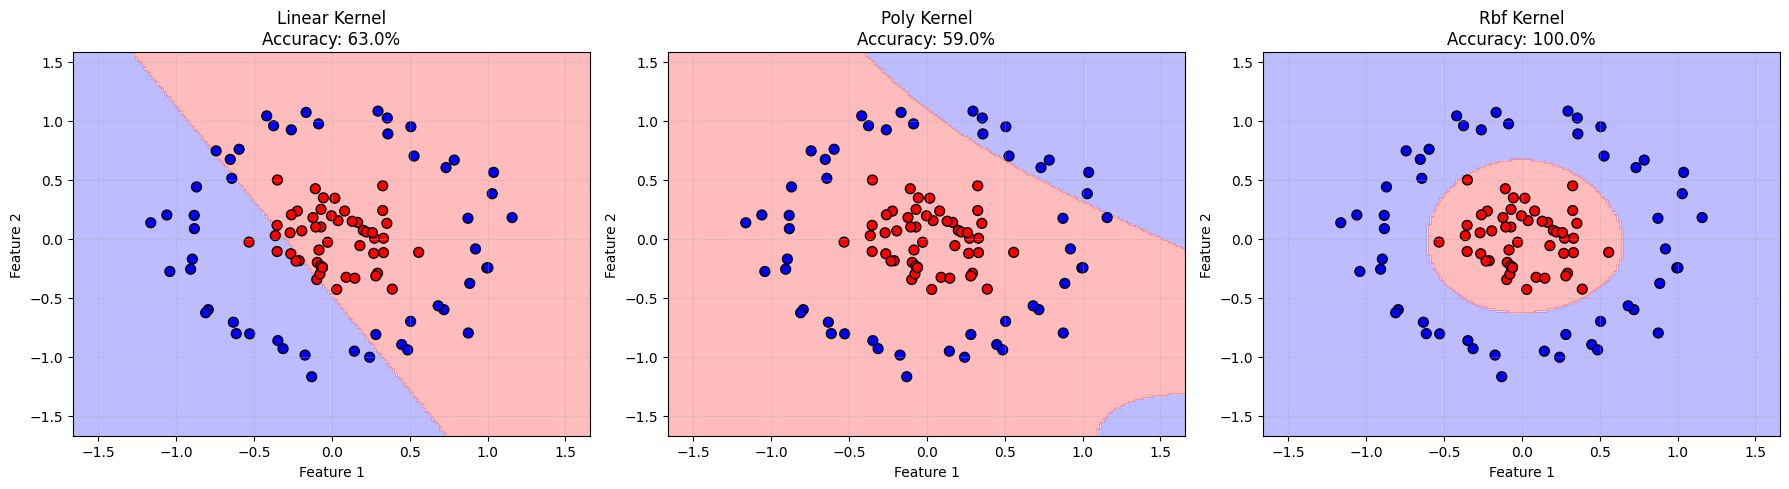

In [4]:
# Quick visualization of different kernels with accuracy in the title
from sklearn.datasets import make_circles

X_circle, y_circle = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=42)

kernels = ['linear', 'poly', 'rbf']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, kernel in enumerate(kernels):
    svm = SVC(kernel=kernel, C=1)
    svm.fit(X_circle, y_circle)
    acc = svm.score(X_circle, y_circle)
    
    ax = axes[idx]
    x_min, x_max = X_circle[:, 0].min() - 0.5, X_circle[:, 0].max() + 0.5
    y_min, y_max = X_circle[:, 1].min() - 0.5, X_circle[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')
    ax.scatter(X_circle[:, 0], X_circle[:, 1], c=y_circle, 
               s=50, cmap='bwr', edgecolors='k')
    ax.set_title(f'{kernel.capitalize()} Kernel\nAccuracy: {acc*100:.1f}%')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


**Observation:**
- We clearly see in the figure that only the Rbf kernel is able to sufficiently separate the two distributions by finding the 2D elipse like decision boundary.

 ## 6. Practical Application: Sentiment Classification with IMDB Dataset
 We will use SVM to classify movie reviews as positive or negative using Bag-of-Words (BOW) features.

In [5]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Counter is a useful package takes as input a list of elements (e.g. a list of words in a text) and 
#  returns a dictionary how many times each element occurs with key (e.g. "apple" ): value ( e.g. 5) .
from collections import Counter, defaultdict
from datasets import load_dataset

In [6]:
imdb_dataset = load_dataset('imdb', split='train')  # Use 5000 samples for speed
imdb_test = load_dataset('imdb', split='test')  # Use 1000 test samples

# Prepare data
X_train_imdb = imdb_dataset['text']
y_train_imdb = ['positive' if label == 1 else 'negative' for label in imdb_dataset['label']]
X_test_imdb = imdb_test['text']
y_test_imdb = ['positive' if label == 1 else 'negative' for label in imdb_test['label']]



# Convert text to BOW features
vectorizer = CountVectorizer(max_features=100, stop_words='english')
X_bow = vectorizer.fit_transform(X_train_imdb)

print(f"BOW feature matrix shape: {X_bow.shape}")
print(f"Number of features (vocabulary size): {len(vectorizer.get_feature_names_out())}")

BOW feature matrix shape: (25000, 100)
Number of features (vocabulary size): 100


 ### 6.1 Training and Evaluating the SVM Classifier

In [ ]:
vectorizer = CountVectorizer(max_features=5000)

#  first do fit on both X_train and X_test to avoid unseen words in test
vectorizer.fit(X_train_imdb + X_test_imdb)
X_bow_train = vectorizer.transform(X_train_imdb)
X_bow_test = vectorizer.transform(X_test_imdb)

In [ ]:
# Train SVM with linear kernel
# svm_classifier = SVC(kernel='linear', C=1.0)
from sklearn.svm import LinearSVC

# Use LinearSVC for faster training on large sparse datasets
svm_classifier = LinearSVC(C=1.0, max_iter=5000)

# Train the classifier
svm_classifier.fit(X_bow_train, y_train_imdb)

# Predictions
y_pred_test = svm_classifier.predict(X_bow_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test_imdb, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test_imdb, y_pred_test, target_names=['Negative', 'Positive']))


Accuracy: 0.81952

Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.83      0.82     12500
    Positive       0.82      0.81      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



 ### 6.2 Feature Importance
 In linear SVM, the weight vector indicates feature importance. Positive weights indicate features associated with the positive class.

In [10]:
# Get feature weights
feature_names = vectorizer.get_feature_names_out()
weights = svm_classifier.coef_[0]

# Sort features by weight
feature_weight_pairs = list(zip(feature_names, weights))
feature_weight_pairs.sort(key=lambda x: x[1])
print("\nTop 10 words indicating NEGATIVE sentiment:")
for word, weight in feature_weight_pairs[:10]:
    print(f" - {word}: {weight:.3f}")

print("\nTop 10 words indicating POSITIVE sentiment:")
for word, weight in feature_weight_pairs[-10:]:
    print(f" - {word}: {weight:.3f}")



Top 10 words indicating NEGATIVE sentiment:
 - unwatchable: -2.395
 - stinker: -2.235
 - baldwin: -2.216
 - obnoxious: -2.115
 - cardboard: -2.107
 - tripe: -1.972
 - uninspired: -1.933
 - unfunny: -1.719
 - disappointment: -1.671
 - unbearable: -1.669

Top 10 words indicating POSITIVE sentiment:
 - hong: 1.691
 - crucial: 1.787
 - showdown: 1.795
 - kung: 2.026
 - vengeance: 2.055
 - solo: 2.292
 - soccer: 2.332
 - flawless: 2.345
 - kitty: 2.454
 - voight: 2.519


**Observation:**
- The top positive and negative sentiment words reveal largely predictable patterns. The negative sentiment class contains especially predictable words, such as "unfunny" and "obnoxious." A limitation of positive sentiment words is that they often appear in negative reviews as well, typically preceded by "not."
- Interestingly, the positive sentiment words suggest the model identified Asian action films as strong positive indicators, as evidenced by terms like "hong" [Kong], "kung" [fu], and action-related words such as "showdown" and "vengeance," which appear to be characteristic of action movies.

## 7. Self-Check Questions

1. What is the main objective of an SVM classifier?
2. How does the parameter C affect the margin and classification errors in SVM?
3. What are support vectors, and why are they important?
4. Why are kernels used in SVMs, and what problem do they solve?
5. In text classification tasks, why are linear kernels commonly used?
6. What is the difference between hard margin and soft margin SVM?
7. How can you interpret feature importance in a linear SVM model?
